In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
from tqdm import tqdm


In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print("Using device:", device)


Using device: mps


In [3]:
class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.img_dir}/{row['image_path']}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = row.get("label", -1)   # test tiene -1
        return image, label


In [4]:
train_df = pd.read_csv("aml-2025-feathers-in-focus/train_images.csv")
test_df  = pd.read_csv("aml-2025-feathers-in-focus/test_images_path.csv")

# labels de 1–200 → convertimos a 0–199
train_df["label"] = train_df["label"] - 1

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 3533
Val size: 393
Test size: 4000


In [5]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [6]:
train_ds = BirdDataset(train_df, "aml-2025-feathers-in-focus/train_images", train_tfms)
val_ds   = BirdDataset(val_df,   "aml-2025-feathers-in-focus/train_images", test_tfms)
test_ds  = BirdDataset(test_df,  "aml-2025-feathers-in-focus/test_images",  test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)


In [7]:
class SimpleBirdCNN(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [8]:
model = SimpleBirdCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [9]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [10]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(5):
    train_loss = train_epoch(model, train_loader, optimizer)
    train_acc  = evaluate(model, train_loader)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

torch.save(model.state_dict(), "cnn_scratch.pth")
print("✓ Modelo guardado")


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


Epoch 1: Train Loss=5.2209, Train Acc=0.0204 | Val Loss=5.0499, Val Acc=0.0127


 63%|██████▎   | 70/111 [00:25<00:15,  2.69it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt


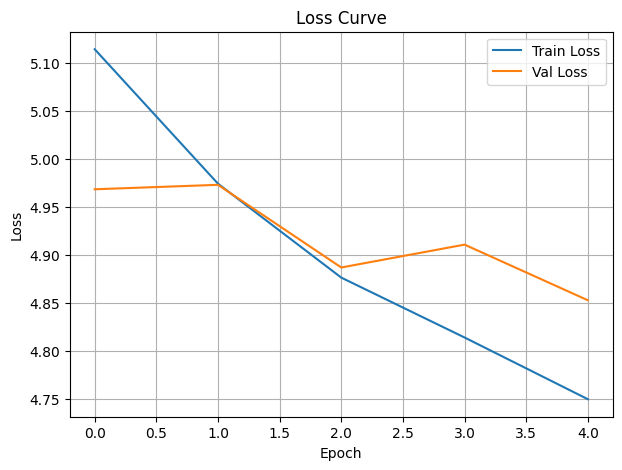

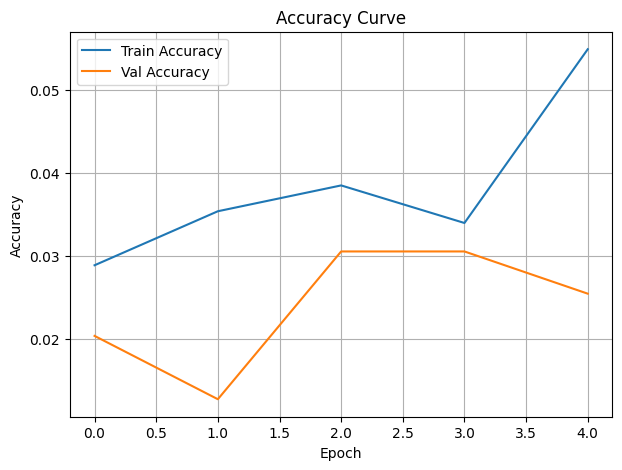

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Res-Net

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
train_ds = BirdDataset(train_df, "aml-2025-feathers-in-focus/train_images", train_tfms)
val_ds   = BirdDataset(val_df,   "aml-2025-feathers-in-focus/train_images", test_tfms)
test_ds  = BirdDataset(test_df,  "aml-2025-feathers-in-focus/test_images",  test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


In [ ]:
class ResNet18Scratch(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [BasicBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
model = ResNet18Scratch(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [ ]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 20   

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    train_acc  = evaluate(model, train_loader)

    # validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(val_loader)

    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

torch.save(model.state_dict(), "resnet18_scratch.pth")
print("✓ Modelo guardado")


100%|██████████| 111/111 [00:34<00:00,  3.22it/s]


Epoch 1/20 | Train Loss=5.3422, Train Acc=0.0173 | Val Loss=5.1792, Val Acc=0.0127


100%|██████████| 111/111 [00:30<00:00,  3.66it/s]


Epoch 2/20 | Train Loss=5.0552, Train Acc=0.0283 | Val Loss=5.0116, Val Acc=0.0280


100%|██████████| 111/111 [00:31<00:00,  3.53it/s]


Epoch 3/20 | Train Loss=4.8961, Train Acc=0.0317 | Val Loss=4.8896, Val Acc=0.0178


100%|██████████| 111/111 [00:31<00:00,  3.49it/s]


Epoch 4/20 | Train Loss=4.7845, Train Acc=0.0470 | Val Loss=4.8867, Val Acc=0.0382


100%|██████████| 111/111 [00:32<00:00,  3.38it/s]
